In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal # used to round the numbers so they look pretty

Now we consider the case where a flock may have multiple species of birds. We suppose there are `num_flocks` flocks and `num_species` species.

In [2]:
# set number of species and flocks
num_flocks = 1 + 1 # +1 chicken surveillence - technically still one flock, add one to make tracking easier. Need to reflect in beta, sigma, and gamma 
num_species = 3


In [3]:
# set initial conditions 

# the following convention will be used: first dimension will represent which flock, second is which species, third is the compartment.
init_val = np.zeros((num_flocks, num_species, 6)) # Six possible compartment: S, E_S, E_A, I_S, I_A, R

# first let all birds to start susceptible, also choose population size here.
init_val[:,:,0] += 100 # 100 birds per flock per species, can be changed

# init_val[1,1,0] -= 100 # no duck suveillance

print(init_val)

# store the total population for each flock and each species
tot_popul = init_val[:,:,0].copy()

# then choose a bird to be exposed (symptomatic), here we assume it to be the first species in the first flock.
init_val[0,0,0] -= 1
init_val[0,0,1] += 1


[[[100.   0.   0.   0.   0.   0.]
  [100.   0.   0.   0.   0.   0.]
  [100.   0.   0.   0.   0.   0.]]

 [[100.   0.   0.   0.   0.   0.]
  [100.   0.   0.   0.   0.   0.]
  [100.   0.   0.   0.   0.   0.]]]


In [4]:
# this is the maximum number of events that would occur, typically the number will not be reached, but 
# for diseases that does not die out this is necessary to not fall into an infinite while loop.
max_events = 500000

# set the time and state sequence
t = [0] + [None] * max_events
y = [init_val] + [None] * max_events


We consider each of the parameter: firstly the infection rate (from symptomatic birds). The $(a,b,c,d)$-th entry of the 4-rank tensor `beta_S` means "the infection rate from a symptomatic infectious bird in flock $a$ species $b$, to flock $c$ species $d$".

In [5]:
# initialise the infection rate tensor
beta_S = np.zeros((num_flocks, num_species, num_flocks, num_species))

# insert some values, can be changed
for a in range(num_flocks):
    for b in range(num_species):
        for c in range(num_flocks):
            for d in range(num_species):
                if a == c and b == d:
                    beta_S[a,b,c,d] = 4
                elif a == c and b != d:
                    beta_S[a,b,c,d] = 3.5
                elif a != c and b == d:
                    beta_S[a,b,c,d] = 1.5
                else:
                    beta_S[a,b,c,d] = 1.2


Same idea applies to asymptomatic birds.

In [6]:
# initialise the infection rate tensor
beta_A = np.zeros((num_flocks, num_species, num_flocks, num_species))

# insert some values, can be changed
for a in range(num_flocks):
    for b in range(num_species):
        for c in range(num_flocks):
            for d in range(num_species):
                if a == c and b == d:
                    beta_A[a,b,c,d] = 2
                elif a == c and b != d:
                    beta_A[a,b,c,d] = 1.8
                elif a != c and b == d:
                    beta_A[a,b,c,d] = 1
                else:
                    beta_A[a,b,c,d] = 0.8


Now consider the latency and infectious period, probability of symptom display.

In [7]:
# latency and infectious period, can be changed
latency_period_S = 1 * np.ones(num_species)
sigma_S = np.ones(num_species) / latency_period_S
latency_period_A = 0.5 * np.ones(num_species)
sigma_A = np.ones(num_species) / latency_period_A

infectious_period_S = 4 * np.ones(num_species)
gamma_S = np.ones(num_species) / infectious_period_S
infectious_period_A = 2 * np.ones(num_species)
gamma_A = np.ones(num_species) / infectious_period_A

# probability of displaying symptoms, can be changed
p_S = np.array([0.8] * num_species)
p_A = np.ones(num_species) - p_S

We have the following update rules for a bird in flock $a$ and of species $b$ (for sympotomatic case only, asymptomatic case follows similar reasoning):
$$ \begin{align*}
S_{(a,b)} &\xrightarrow{ p_{Sb} \sum_{(i,j)} \frac{1}{N_{i,j}} (\beta_{S(i,j,a,b)} I_{S(i,j)} + \beta_{A(i,j,a,b)} I_{A(i,j)})}E_{S(a,b)} \\
E_{S(a,b)} &\xrightarrow{\sigma_{Sb}} I_{S(a,b)} \\
I_{S(a,b)} &\xrightarrow{\gamma_{Sb}} R_{(a,b)}
\end{align*}
$$

We define each of the rules into a function.

In [8]:
# initialise the event count and current values

num_event = 0
current_val = init_val.copy()


In [9]:
def S_to_E(a, b, current_val, symptomatic = True, tot_popul=tot_popul, beta_S=beta_S, beta_A=beta_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, num_species=num_species):
    val = 0
    for i in range(num_flocks):
        for j in range(num_species):
            if tot_popul[i,j] != 0:
                val += (beta_S[i,j,a,b] * current_val[i,j,3] + beta_A[i,j,a,b] * current_val[i,j,4]) / tot_popul[i,j]
    if symptomatic:
        val = val * current_val[a,b,0] * p_S[b]
    else:
        val = val * current_val[a,b,0] * p_A[b]
    return val

def E_to_I(a, b, current_val, symptomatic = True, tot_popul=tot_popul, sigma_S=sigma_S, sigma_A=sigma_A, num_flocks=num_flocks, num_species=num_species):
    if symptomatic:
        return current_val[a,b,1] * sigma_S[b]
    else:
        return current_val[a,b,2] * sigma_A[b]

def I_to_R(a, b, current_val, symptomatic = True, tot_popul=tot_popul, gamma_S=gamma_S, gamma_A=gamma_A, num_flocks=num_flocks, num_species=num_species):
    if symptomatic:
        return current_val[a,b,3] * gamma_S[b]
    else:
        return current_val[a,b,4] * gamma_A[b]
    

In [10]:
while (num_event < max_events) and (np.sum(current_val[:,:,1:5]) > 0): # stop the loop if: 1. maximum event number is reached, or 2. no more infections can possibly occur.
    
    num_event += 1

    ##### create an event tensor ####

    all_events = np.zeros((num_flocks, num_species, 6)) # six types of update rules in total

    for a in range(num_flocks):
        for b in range(num_species):
            all_events[a,b,0] = S_to_E(a, b, current_val, True)
            all_events[a,b,1] = S_to_E(a, b, current_val, False)
            all_events[a,b,2] = E_to_I(a, b, current_val, True)
            all_events[a,b,3] = E_to_I(a, b, current_val, False)
            all_events[a,b,4] = I_to_R(a, b, current_val, True)
            all_events[a,b,5] = I_to_R(a, b, current_val, False)

    # store total rate to rescale later
    tot_rate = np.sum(all_events)
    
    # do a time leap
    
    r1 = np.random.uniform()
    t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
    
    # then choose events, first choose the type of events (S to E_S, S to E_A, E_S to I_S, E_A to I_A, I_S to R, or I_A to R)
    
    r2 = np.random.uniform()

    for event in range(6):
        if r2 < np.sum(all_events[:,:,0:event+1]) / tot_rate:
            type_event = event
            break

    # then choose which flock gets updated
    
    r3 = np.random.uniform()
    spec_event_rate = np.sum(all_events[:,:,type_event]) # total rate of a specific event occurring

    for i in range(num_flocks):
        if r3 < np.sum(all_events[0:i+1,:,type_event]) / spec_event_rate:
            flock_to_update = i
            break

    # finally choose which species get updated

    r4 = np.random.uniform()
    spec_event_flock_rate = np.sum(all_events[flock_to_update,:,type_event])

    for j in range(num_species):
        if r4 < np.sum(all_events[flock_to_update,0:j+1,type_event]) / spec_event_flock_rate:
            species_to_update = j
            break

    # do the updating
    if type_event == 0:
        current_val[flock_to_update, species_to_update, 0] -= 1
        current_val[flock_to_update, species_to_update, 1] += 1
    if type_event == 1:
        current_val[flock_to_update, species_to_update, 0] -= 1
        current_val[flock_to_update, species_to_update, 2] += 1
    if type_event == 2:
        current_val[flock_to_update, species_to_update, 1] -= 1
        current_val[flock_to_update, species_to_update, 3] += 1
    if type_event == 3:
        current_val[flock_to_update, species_to_update, 2] -= 1
        current_val[flock_to_update, species_to_update, 4] += 1
    if type_event == 4:
        current_val[flock_to_update, species_to_update, 3] -= 1
        current_val[flock_to_update, species_to_update, 5] += 1
    if type_event == 5:
        current_val[flock_to_update, species_to_update, 4] -= 1
        current_val[flock_to_update, species_to_update, 5] += 1

    # store the updated value

    y[num_event] = current_val.copy()

# get rid of none value if there is any:
t = np.array(t[0:num_event+1])
y = np.array(y[0:num_event+1])
        

Some plots can be made here.

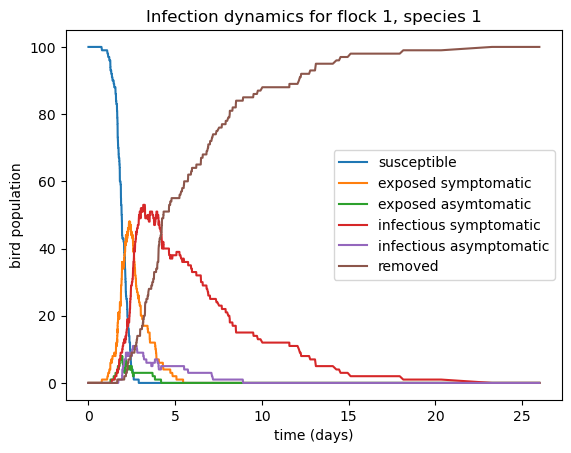

In [11]:
show_flock = 1
show_species = 1

plt.plot(t, y[:, show_flock, show_species, 0], label='susceptible')
plt.plot(t, y[:, show_flock, show_species, 1], label='exposed symptomatic')
plt.plot(t, y[:, show_flock, show_species, 2], label='exposed asymtomatic')
plt.plot(t, y[:, show_flock, show_species, 3], label='infectious symptomatic')
plt.plot(t, y[:, show_flock, show_species, 4], label='infectious asymptomatic')
plt.plot(t, y[:, show_flock, show_species, 5], label='removed')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('bird population')
plt.title(f'Infection dynamics for flock {show_flock}, species {show_species}')

plt.show()

We can define a few functions that allows us to collect some key statistics and plot some graphs.

In [12]:
# function that allows aggregated data depending on specified flock or species.

def aggregate(y, flock_lst: list, species_lst: list):
    y = y[:, flock_lst][:, :, species_lst,:]
    return np.sum(y, axis=(1,2))

# function to do plotting: choose which flocks and species to consider, add the total up, 
# choose which compartment to show

def dynamics_plot_aggregate(t, y, flock_lst: list, species_lst: list,
                            susceptible=True, exposed_symptomatic=True,
                            exposed_asymptomatic=True, infectious_symptomatic=True,
                            infectious_asymptomatic=True, removed=True):
    y_aggregated = aggregate(y, flock_lst, species_lst)
    if susceptible:
        plt.plot(t, y_aggregated[:, 0], label='susceptible')
    if exposed_symptomatic:
        plt.plot(t, y_aggregated[:, 1], label='exposed symtomatic')
    if exposed_asymptomatic:
        plt.plot(t, y_aggregated[:, 2], label='exposed asymtomatic')
    if infectious_symptomatic:
        plt.plot(t, y_aggregated[:, 3], label='infectious symtomatic')
    if infectious_asymptomatic:
        plt.plot(t, y_aggregated[:, 4], label='infectious asymtomatic')
    if removed:
        plt.plot(t, y_aggregated[:, 5], label='removed')
    plt.legend()
    plt.xlabel('time (days)')
    plt.ylabel('bird population')
    plt.title(f'Infection dynamics for flock {flock_lst}, species {species_lst}, aggregated')

    plt.show()


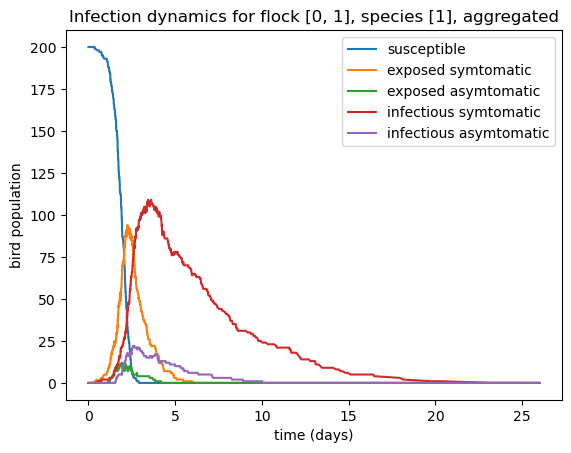

In [15]:
# example:
dynamics_plot_aggregate(t,y,[0,1], [1], removed=False)